# Counting objects

## Coins image

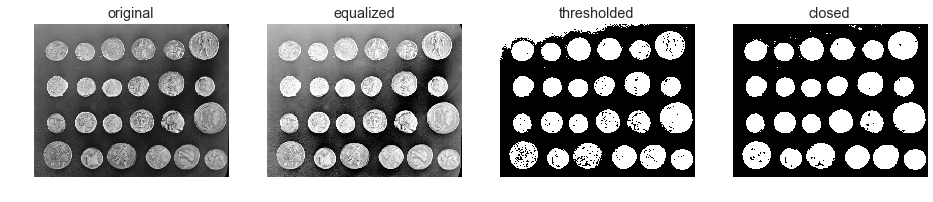

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.exposure import equalize_hist
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import closing
from skimage.measure import label, regionprops

coins_img = data.coins()
n = 4
fig, ax = plt.subplots(1,n,figsize=(4*n,5))
for j in range(len(ax)):
    ax[j].axis('off')
ax[0].imshow(coins_img, cmap='gray')
ax[0].set_title('original')

# Equalize image
coins_eqlzd = equalize_hist(coins_img)
ax[1].imshow(coins_eqlzd, cmap='gray')
ax[1].set_title('equalized')

# Threshold image
coins_thresh = threshold_otsu(coins_img)
thresh_image = coins_img >= coins_thresh + 5 # +5 required to not lose top right coin!
ax[2].imshow(thresh_image, cmap='gray')
ax[2].set_title('thresholded')

# Clear border
img2 = clear_border(thresh_image)

# Morphological closing
img2 = closing(img2)
ax[3].imshow(img2, cmap='gray')
ax[3].set_title('closed')

plt.show()

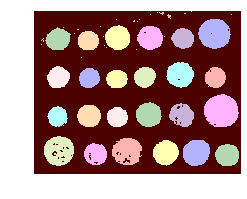

In [4]:
from skimage.color import label2rgb
# Regions, and remove small objects
labels = label(img2)
region_props = regionprops(labels, intensity_image=img2)

area_thresh = 1000

small_region_labels = [small_region.label for small_region in region_props if small_region.area < area_thresh]

pts_in_small_regions = [ np.in1d(pixel, small_region_labels) for pixel in labels]
labels[pts_in_small_regions] = 0

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.axis('off')
ax.imshow(label2rgb(labels, image=img2))
plt.show()

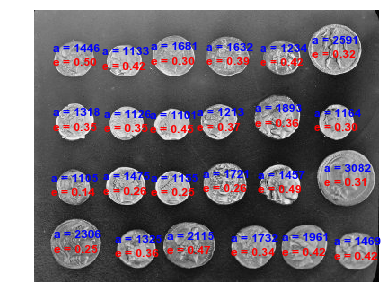

In [6]:
# Calculate area and eccentricity for each coin
region_props = regionprops(labels, intensity_image=img2)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.axis('off')
plt.imshow(coins_img, cmap='gray')

for region in region_props:
    (minr, minc, maxr, maxc) = region.bbox
    a = region.area
    e = region.eccentricity
    plt.text((minc+maxc)/2-25, (minr+maxr)/2 - 8, f'a = {a:.0f}', color='blue', weight='bold', fontsize=12)
    plt.text((minc+maxc)/2-25, (minr+maxr)/2 + 8, f'e = {e:.2f}', color='red', weight='bold', fontsize=12)
plt.show()

# Panorama stitching

## getting started

In [7]:
from __future__ import division, print_function
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

## Image collection

In [9]:
import skimage.io as io

pano_imgs = io.ImageCollection('./pano_v0/*.jpg')
compare(*pano_imgs, figsize=(12, 10))

## preprocessing

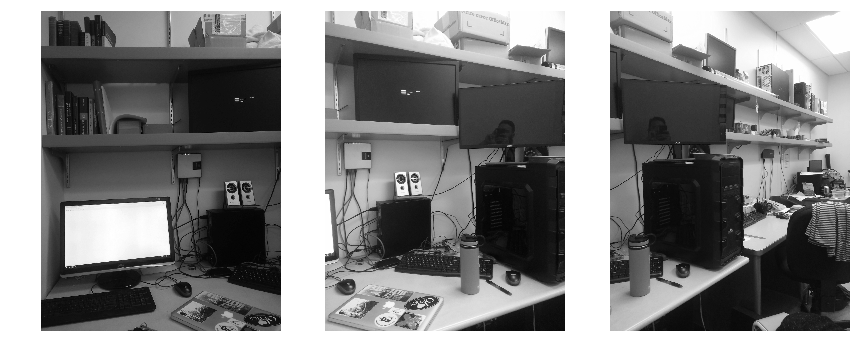

In [10]:
from skimage.color import rgb2gray

pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]
# View the results
compare(pano0, pano1, pano2, figsize=(12, 10))

## feature detection and matching

In [11]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

In [12]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

In [13]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
# Best match subset for pano0 -> pano1
plot_matches(ax[0], pano0, pano1, keypoints0, keypoints1, matches01)
ax[0].axis('off');

# Best match subset for pano1 -> pano2
plot_matches(ax[1], pano1, pano2, keypoints1, keypoints2, matches12)
ax[1].axis('off');

## transform estimation

In [22]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

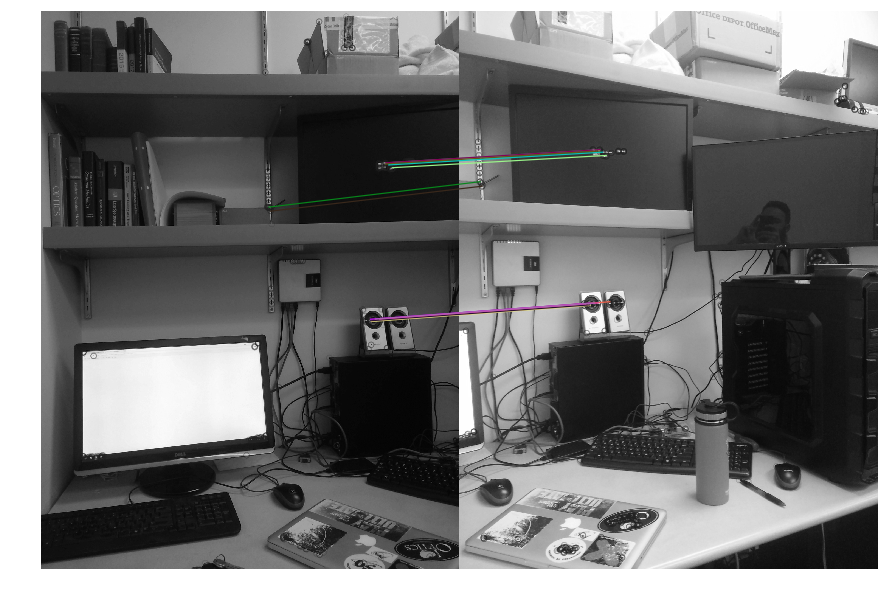

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

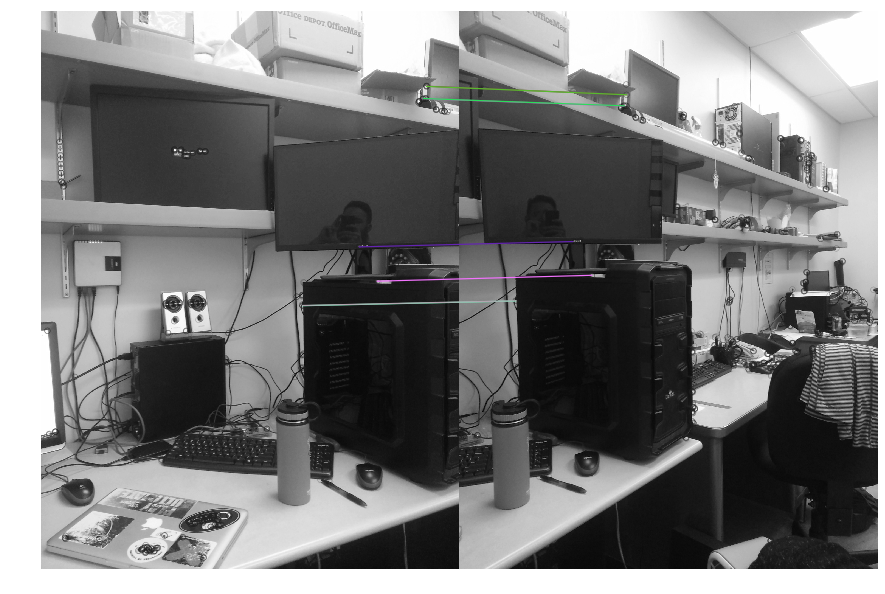

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

## Warping

In [25]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

## apply estimated transforms

In [26]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

Warp left panel into place

In [27]:
# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

Warp right panel into place

In [28]:
# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

Inspect the warped images

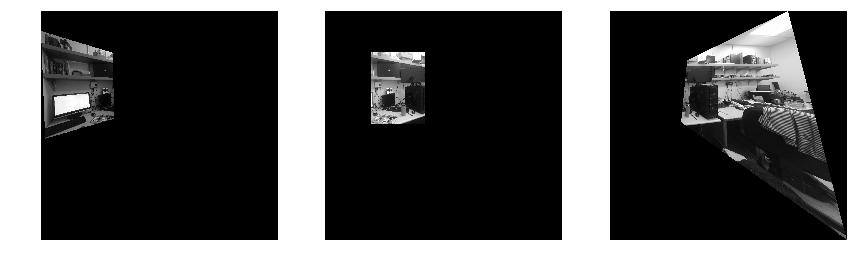

In [29]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10));

## Combining images the easy and bad way:

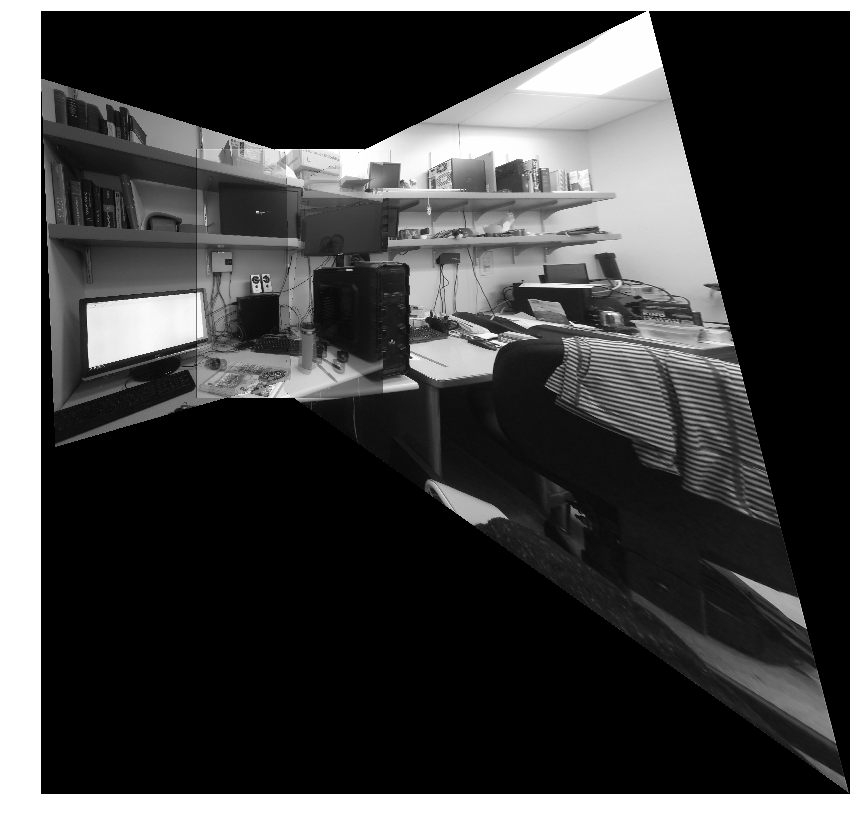

In [30]:
# Add the three images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano0_warped + pano1_warped + pano2_warped)

# Track the overlap by adding the masks together
overlap = (pano0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           pano1_mask + 
           pano2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

## Stitching images along a minimum cost path

Define seed points

In [31]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

Construct cost array

In [32]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Generate cost array

In [33]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

# Allow the path to "slide" along top and bottom edges to the optimal horizontal
# position by setting top and bottom edges to zero cost.
costs01[0,  :] = 0
costs01[-1, :] = 0

Visualize cost array

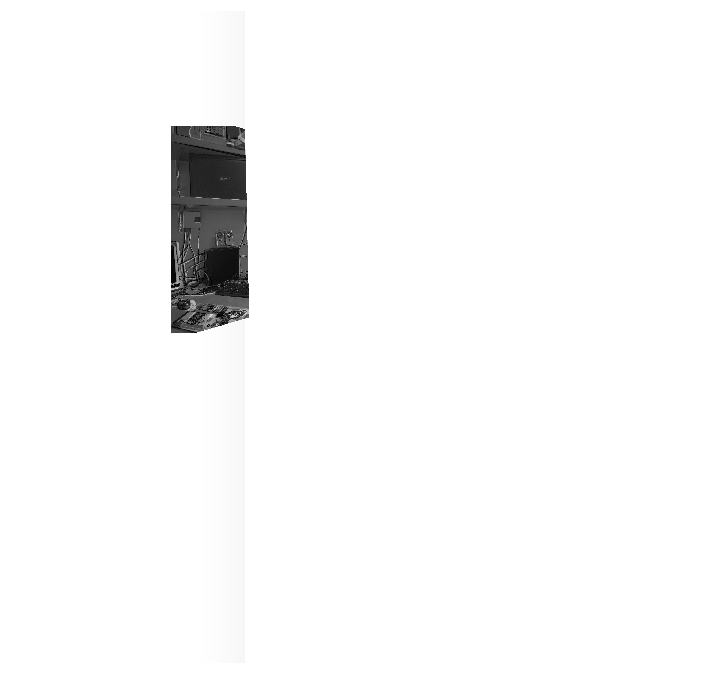

In [34]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');

# Minimum cost path

In [35]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

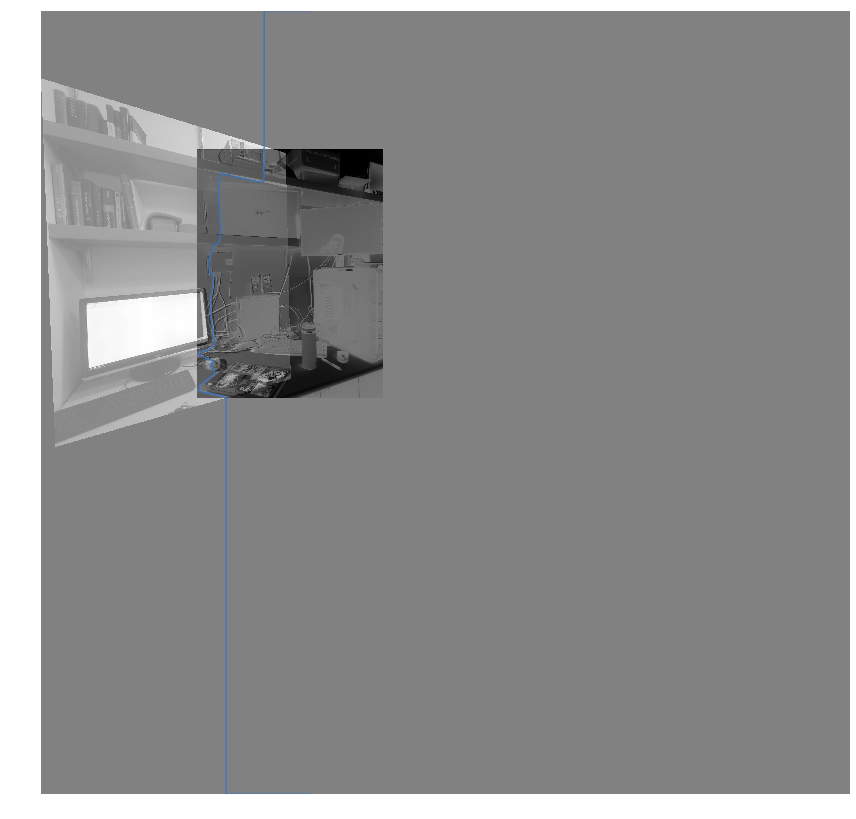

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

Filling the mask

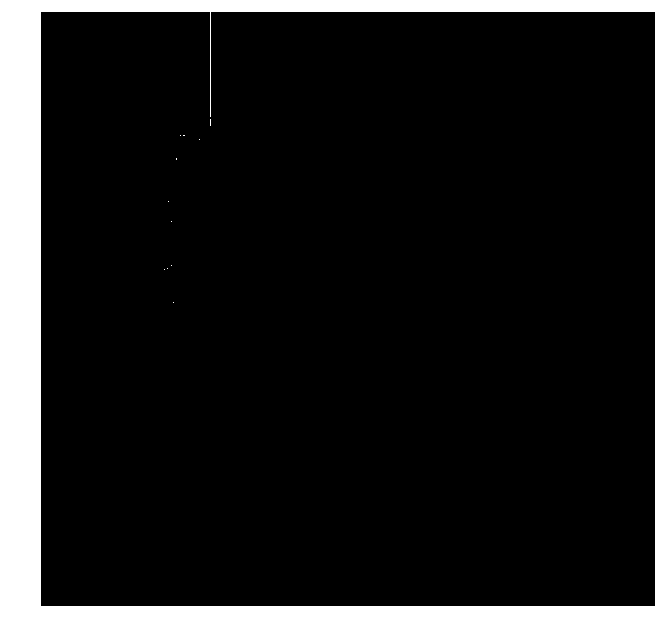

In [37]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1


fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');

In [38]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray')

In [39]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

# Add an additional constraint this time, to prevent this path crossing the prior one!
costs12[mask0 > 0] = 1

(-0.5, 8443.5, 8180.5, -0.5)

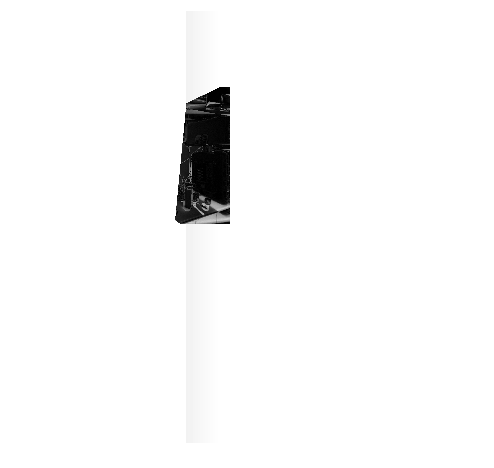

In [40]:
# Check the result
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');
ax.axis('off')

Compute minimal cost path

In [41]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

Verify reasonable result

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

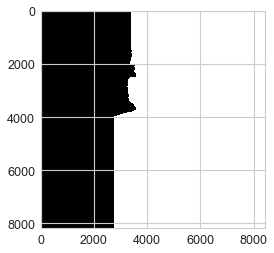

In [43]:
# Initialize the mask by placing the path in a new array

mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1



# Fill the right side this time, again using skimage.measure.label - the label of interest is 2
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask2, cmap='gray');

# Final Mask

In [44]:
mask1 = ~(mask0 | mask2).astype(bool)

In [45]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

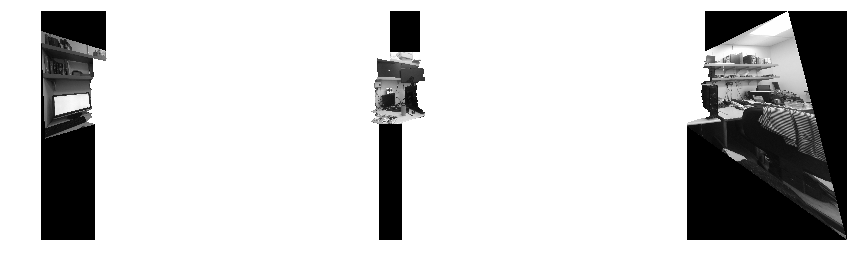

In [46]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

# In color!

Transform the colored images

In [48]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

Apply custom alpha channel masks

In [49]:
pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)

View result!

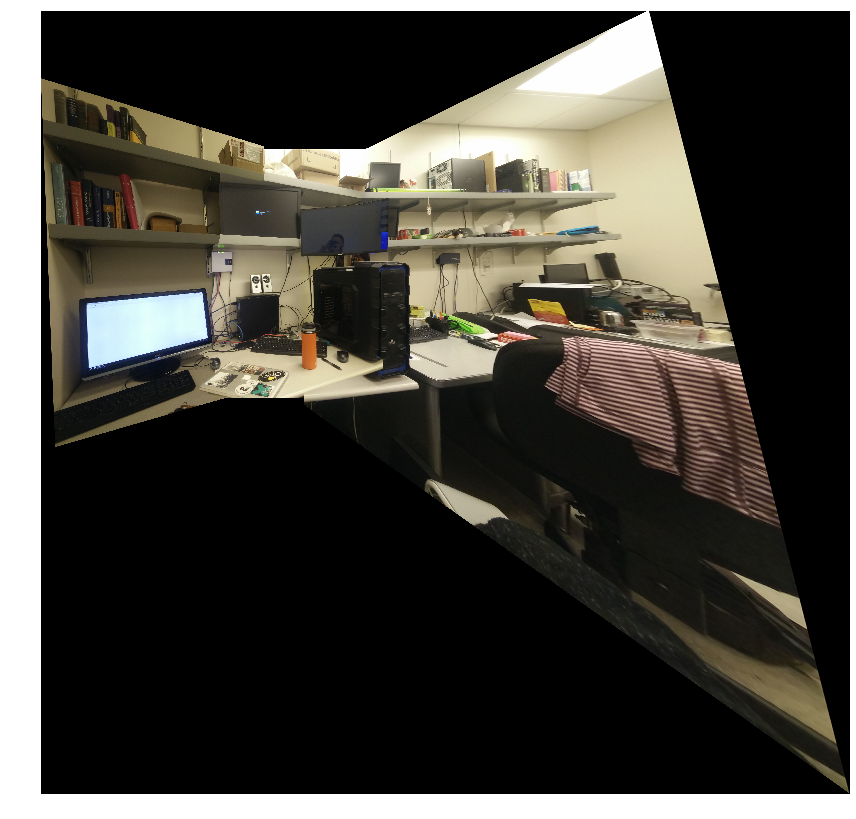

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

Save

In [51]:
from skimage.color import gray2rgb

# Start with empty image
pano_combined = np.zeros_like(pano0_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano0_color * gray2rgb(mask0)
pano_combined += pano1_color * gray2rgb(mask1)
pano_combined += pano2_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./pano-advanced-output.png', pano_combined)

/Users/mattjaffe/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
